In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 18.3MB/s]


In [5]:
!unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


# XGBoost Classifier

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## Loading Dataset

In [6]:
train_path = "/content/train.csv"
test_path = "/content/test.csv"
gender_sub_path = "/content/gender_submission.csv"

In [8]:
def load_dataset(filename: str):
    return pd.read_csv(filename)

### Loading training data

In [9]:
train_df = load_dataset(train_path)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Deleting unnecessary columns using class

### checking columns whicha have more than 50% null values

In [13]:
def colfinder(dataframe, min_ratio=0.5):
    filter = (dataframe.isnull().sum() / dataframe.shape[0]) > min_ratio
    return list(dataframe.columns[filter])

### There are some columns in the dataset, which would not be useful for training the machine learning algorithm.

In [14]:
col_not_helpful = ['Name', 'Ticket', 'PassengerId'] + colfinder(train_df)

col_not_helpful

['Name', 'Ticket', 'PassengerId', 'Cabin']

## Delete list of columns from dataframe

In [15]:
def delete_columns(dataframe, lst):
    return dataframe.drop(lst, axis=1)

In [16]:
train_df1 = delete_columns(train_df, col_not_helpful)

train_df1.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Visualizing the data

In [20]:
num_df = train_df1.select_dtypes(include="number")
cat_df = train_df1.select_dtypes(include="object")

num_attributes = num_df.columns
cat_attributes = cat_df.columns

num_attributes, cat_attributes

(Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object'),
 Index(['Sex', 'Embarked'], dtype='object'))

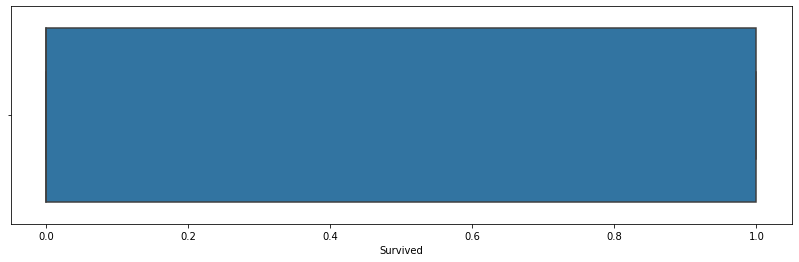

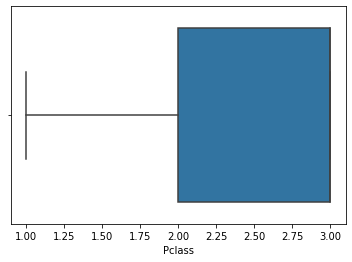

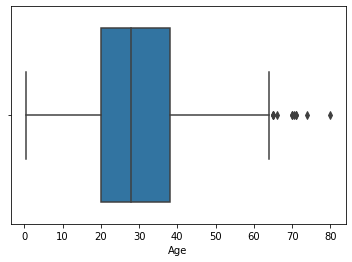

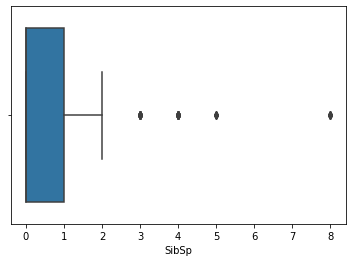

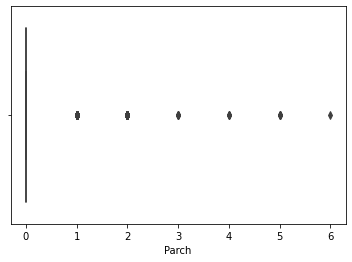

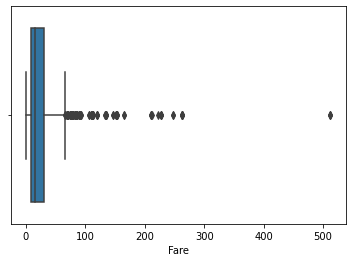

In [21]:
plt.figure(figsize=(14, 4))
for col in num_df:
    sns.boxplot(x=col, data=num_df)
    plt.show()

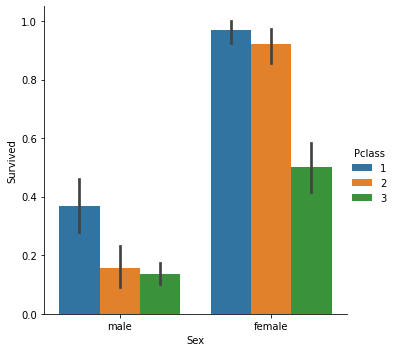

In [22]:
sns.catplot(x='Sex', y='Survived', data=train_df1, kind='bar', hue='Pclass')

From the boxplot of age and fare, it can be said that age and fare has outliers.

In [23]:
print(f"The skewness of the age column of the titanic dataset is: {train_df1['Age'].skew()}")
print(f"The skewness of the fare column of the titanic dataset is: {train_df1['Fare'].skew()}")

The skewness of the age column of the titanic dataset is: 0.38910778230082704
The skewness of the fare column of the titanic dataset is: 4.787316519674893


As the skewness of the fare column is not within range -1 to +1. We would remove all the outliers from it.

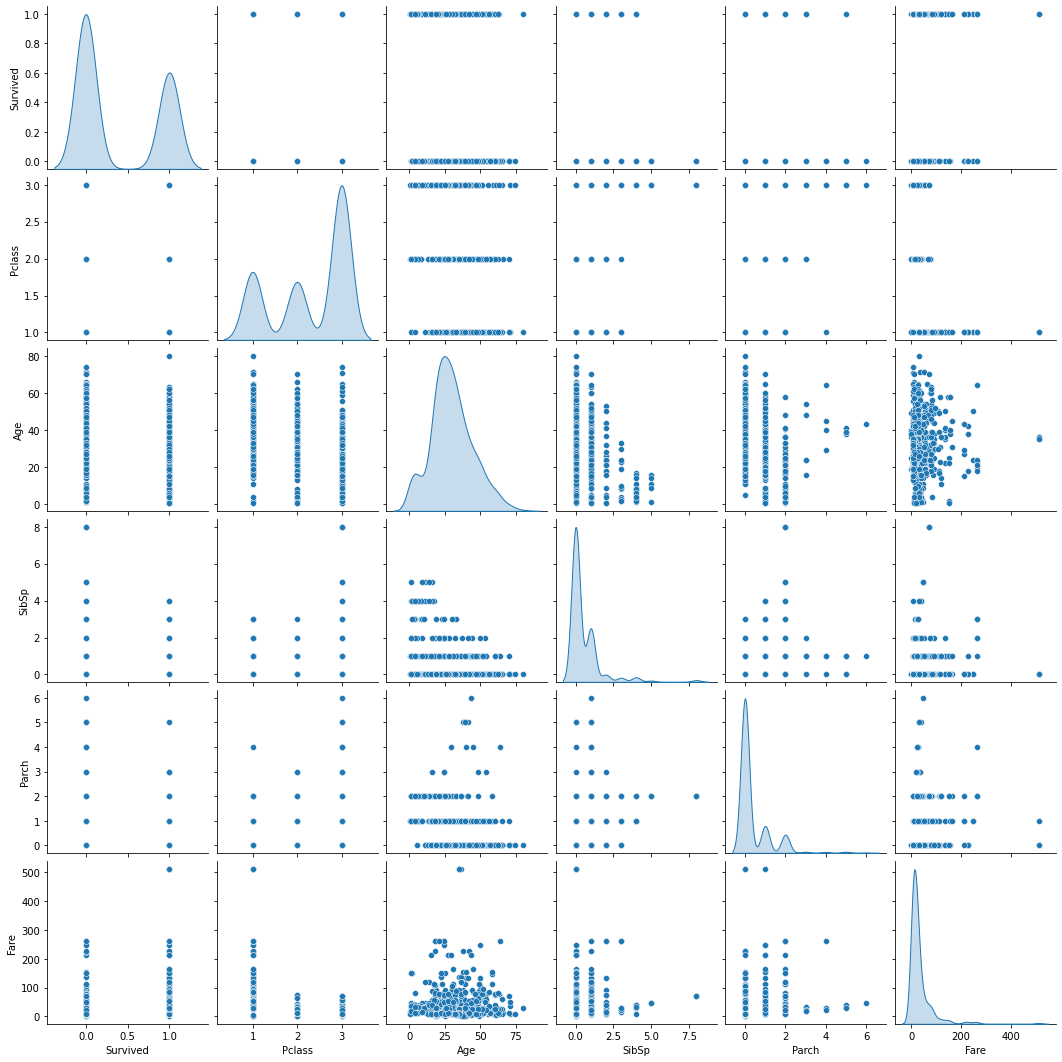

In [25]:
sns.pairplot(data=num_df, diag_kind='kde')

## Filling missing values of numerical attributes by median and categorical variables by mode.

In [26]:
def filling_missing_values(X):
    num_attributes = X.select_dtypes(include="number").columns
    cat_attributes = X.select_dtypes(include="object").columns

    [X[num_col].fillna(X[num_col].median(), inplace=True) for num_col in num_attributes]
    [X[cat_col].fillna(X[cat_col].mode()[0], inplace=True) for cat_col in cat_attributes]

In [27]:
filling_missing_values(train_df1)

train_df1.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Outlier removing of fair and age using IQR

In [28]:
def outlier_removal(X, col_name, whisker=1.5):
    """
    This function takes dataframe, column names, whisker length and
    returns a dataframe with all rows removed having outliers in that
    particular column
    """
    Q1 = X[col_name].quantile(0.25)
    Q3 = X[col_name].quantile(0.75)
    IQR = Q3 - Q1
    filter = (X[col_name] < Q1 - whisker * IQR) | (X[col_name] > Q3 + whisker * IQR)
    index = X[filter].index
    return X.drop(index)

In [29]:
train_df_outlier_removed = outlier_removal(train_df1, 'Fare', 2.2)

print('The percentage of data removed from the data frame as a consequence \
of outlier removal is ',\
      round((train_df1.shape[0]-train_df_outlier_removed.shape[0])/train_df1.shape[0]*100,2))
print('If you think that the percentage of data removal is more, \
the whiskers length given in the function call can be increased ')

The percentage of data removed from the data frame as a consequence of outlier removal is  8.31
If you think that the percentage of data removal is more, the whiskers length given in the function call can be increased 


In [30]:
X = train_df_outlier_removed.drop('Survived', axis=1).reset_index(drop=True)
y = train_df_outlier_removed['Survived'].reset_index(drop=True)

## Applying onehot encoder to categorical variable

In [32]:
ohc = OneHotEncoder()

X = X.join(pd.DataFrame(ohc.fit_transform(X[cat_attributes]).toarray()))

In [33]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,0,1,2,3,4
0,3,male,22.0,1,0,7.2500,S,0.0,1.0,0.0,0.0,1.0
1,1,female,38.0,1,0,71.2833,C,1.0,0.0,1.0,0.0,0.0
2,3,female,26.0,0,0,7.9250,S,1.0,0.0,0.0,0.0,1.0
3,1,female,35.0,1,0,53.1000,S,1.0,0.0,0.0,0.0,1.0
4,3,male,35.0,0,0,8.0500,S,0.0,1.0,0.0,0.0,1.0


In [37]:
X.Sex.unique(), X.Embarked.unique()

(array(['male', 'female'], dtype=object), array(['S', 'C', 'Q'], dtype=object))

In [38]:
X.drop(['Sex', 'Embarked'], axis=1, inplace=True)
X

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
812,2,27.0,0,0,13.0000,0.0,1.0,0.0,0.0,1.0
813,1,19.0,0,0,30.0000,1.0,0.0,0.0,0.0,1.0
814,3,28.0,1,2,23.4500,1.0,0.0,0.0,0.0,1.0
815,1,26.0,0,0,30.0000,0.0,1.0,1.0,0.0,0.0


## Splitting the dataset into training and testing

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [41]:
len(X_train), len(X_test)

(653, 164)

## Applying XGBoost Classifier

In [43]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)

XGBClassifier()

In [44]:
xgbc.score(X_train, y_train)

0.8836140888208269

In [45]:
xgbc.score(X_test, y_test)

0.8170731707317073

As the problem is overfitting in nature, we shall try to minimise this using grid search cv and randomised search cv and early stopping

## Building a grid search CV and Randomsearch CV module in single function

In [46]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Also applying stratifiedkfold instead of cv
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

In [47]:
def grid_rand_search(X, y, model, params, random=False):
    if random:
        grid = RandomizedSearchCV(model, params, n_jobs=-1, cv=kfold, n_iter=20)
    else:
        grid = GridSearchCV(model, params, n_jobs=-1, cv=kfold)
    grid.fit(X, y)
    best_params = grid.best_params_
    best_score = grid.best_score_
    print("The best params of the models are:", best_params)
    print("The best score of the model is:", best_score)

In [48]:
params = {'n_estimators': [50, 100, 200, 300, 400, 500, 600, 700]}
grid_rand_search(X, y, xgbc, params)

The best params of the models are: {'n_estimators': 600}
The best score of the model is: 0.8311237468202904


In [50]:
params={'learning_rate':[0.01,0.05,0.1,0.3,0.5,0.7,0.9],'n_estimators':[600]}
grid_rand_search(X,y,xgbc,params)

The best params of the models are: {'learning_rate': 0.05, 'n_estimators': 600}
The best score of the model is: 0.8323432590154123


In [51]:
params={'max_depth':[2,3,5,6,8],'learning_rate':[0.05],'n_estimators':[600]}
grid_rand_search(X,y,xgbc,params)

The best params of the models are: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600}
The best score of the model is: 0.8323432590154123


In [52]:
params={'gamma':[0,0.1,0.5,1,2,5],'max_depth':[3],'learning_rate':[0.05],'n_estimators':[600]}
grid_rand_search(X,y,xgbc,params)

The best params of the models are: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 600}
The best score of the model is: 0.8323432590154123


In [53]:
params={'min_child_weight':[1,2,3,4,5], 'gamma':[0],'max_depth':[3],'learning_rate':[0.05],'n_estimators':[600]}
grid_rand_search(X,y,xgbc,params)

The best params of the models are: {'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600}
The best score of the model is: 0.8323432590154123


# using RandomisedSearchCV

In [54]:
params={
    'subsample':[0.3,0.5,0.7,0.9],
    'gamma':[0,0.1,0.5,1,2,5],
    'learning_rate':[0.05,0.1,0.3,0.5,0.7,0.9],
    'max_depth':[1,2,3,4,5,6,7],
    'n_estimators':[50,100,150,200,300,400]
}
grid_rand_search(X,y,xgbc,params,random=True)

The best params of the models are: {'subsample': 0.7, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0}
The best score of the model is: 0.8323432590154123


In [55]:
xgbc.set_params(subsample=0.7, n_estimators=100, max_depth=6, learning_rate=0.1, gamma=0)

XGBClassifier(max_depth=6, subsample=0.7)

In [58]:
df_test=load_dataset(test_path)
id_=df_test['PassengerId']

In [59]:
df_test.drop(['Name','Ticket','Cabin','PassengerId'],axis=1,inplace=True)
df_test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S
...,...,...,...,...,...,...,...
413,3,male,NaN,0,0,8.0500,S
414,1,female,39.0,0,0,108.9000,C
415,3,male,38.5,0,0,7.2500,S
416,3,male,NaN,0,0,8.0500,S


In [60]:
filling_missing_values(df_test)
df_test=df_test.join(pd.DataFrame(ohc.fit_transform(df_test[cat_attributes]).toarray()))
df_test.drop(['Sex','Embarked'],axis=1,inplace=True)
df_test

,Pclass,Age,SibSp,Parch,Fare,0,1,2,3,4
0,3,34.5,0,0,7.8292,0.0,1.0,0.0,1.0,0.0
1,3,47.0,1,0,7.0000,1.0,0.0,0.0,0.0,1.0
2,2,62.0,0,0,9.6875,0.0,1.0,0.0,1.0,0.0
3,3,27.0,0,0,8.6625,0.0,1.0,0.0,0.0,1.0
4,3,22.0,1,1,12.2875,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
413,3,27.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0
414,1,39.0,0,0,108.9000,1.0,0.0,1.0,0.0,0.0
415,3,38.5,0,0,7.2500,0.0,1.0,0.0,0.0,1.0
416,3,27.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0


In [62]:
y_pred=xgbc.predict(df_test)

In [63]:
from sklearn.metrics import confusion_matrix, classification_report

In [70]:
cnf_matrix = confusion_matrix(id_, y_pred)

In [71]:
classification_report(id_, y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

'              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00       0.0\n           1       0.00      0.00      0.00       0.0\n         892       0.00      0.00      0.00       1.0\n         893       0.00      0.00      0.00       1.0\n         894       0.00      0.00      0.00       1.0\n         895       0.00      0.00      0.00       1.0\n         896       0.00      0.00      0.00       1.0\n         897       0.00      0.00      0.00       1.0\n         898       0.00      0.00      0.00       1.0\n         899       0.00      0.00      0.00       1.0\n         900       0.00      0.00      0.00       1.0\n         901       0.00      0.00      0.00       1.0\n         902       0.00      0.00      0.00       1.0\n         903       0.00      0.00      0.00       1.0\n         904       0.00      0.00      0.00       1.0\n         905       0.00      0.00      0.00       1.0\n         906       0.00      0.00      0.00       1.0\n       